# Creating the Initial Conditions

First, import packages to re-create and visualize the model fields here:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Defining the input directory. This directory also contains the bathymetry file.

In [2]:
# define the input directory
input_dir = '/Users/sofia/Documents/CS185C/project/input'

### Downloading the ECCO fields
I downloaded the files for THETA, SALT, UVEL, VVEL, and ETAN fields that apply to the year 2008. Along with this, I downloaded the corresponding grid files that pertain to my model. These files were stored in the data directory.

In [3]:
data_folder = '/Users/sofia/Documents/CS185C/project/data'

### Reading in the ECCO grid
Using the `grid` module from the imported package `eccoseas.ecco` [HERE](https://github.com/mhwood/eccoseas), I can read in the ECCO fields.

In [4]:
from eccoseas.ecco import grid

In [6]:
ecco_XC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='XC')
ecco_YC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='YC')
ecco_hFacC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacC')
ecco_hFacW_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacW')
ecco_hFacS_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacS')
ecco_RF_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='RF')

### Reading in the Model Grid and Generating a Mask

In this step, I will need to recreate my model grid and make a mask that distinguishes between ocean and land. This will determine where the interpolation happens.

In [7]:
# define the parameters that will be used in the data file
delX = 1/12
delY = 1/16
xgOrigin = -75
ygOrigin = 26
n_rows = 360
n_cols = 240

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'EastCoast_bathymetry.bin'),'>f4').reshape(np.shape(XC))

In [8]:
from eccoseas.downscale import hFac

In [9]:
depth = bathy
delR = np.array([ 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.01,
                 10.03, 10.11, 10.32, 10.80, 11.76, 13.42, 16.04, 19.82, 24.85,
                 31.10, 38.42, 46.50, 55.00, 63.50, 71.58, 78.90, 85.15, 90.18,
                 93.96, 96.58, 98.25, 99.25,100.01,101.33,104.56,111.33,122.83,
                 139.09,158.94,180.83,203.55,226.50,249.50,272.50,295.50,318.50,
                 341.50,364.50,387.50,410.50,433.50,456.50,])
hFacC = hFac.create_hFacC_grid(depth, delR)

In [10]:
mask = np.copy(hFacC)
mask[mask>0] = 1

Now, I will plot the mask in comparison to the bathymetry.

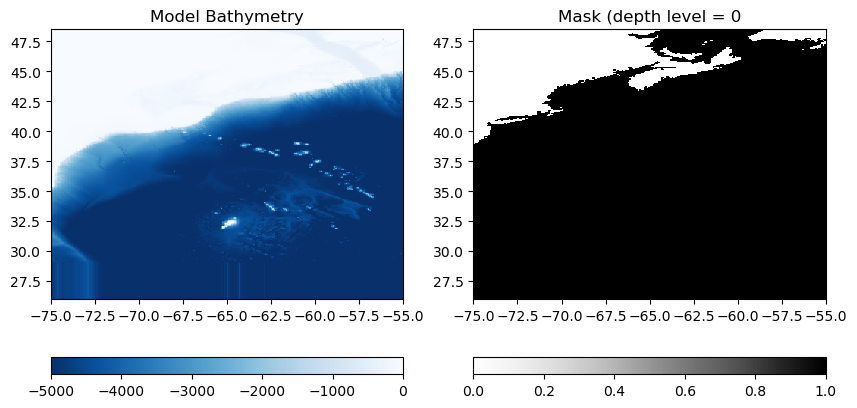

In [11]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

depth_level = 0
plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, mask[0], vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Mask (depth level = '+str(depth_level))

plt.show()

### Preparing the grids for interpolation
I found that the tile 11 has the points I need for my model.

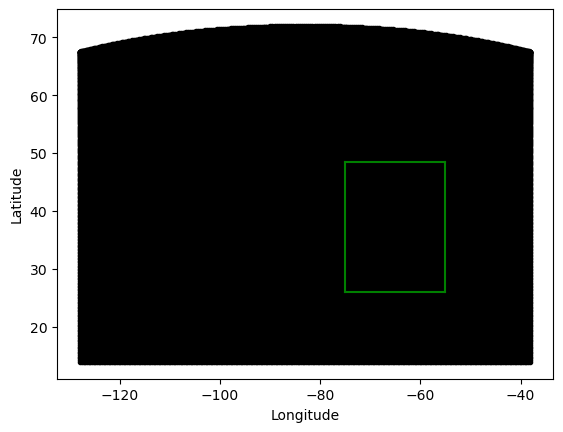

In [12]:
# plot the ECCO tile points from tile 11
plt.plot(ecco_XC_tiles[11],ecco_YC_tiles[11],'k.')

# plot the boundary of the East Coast model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [13]:
tile_list = [8,11]

# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_hFacC_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacW_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacS_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_mask_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()
    
    for k in range(np.size(ecco_RF_tiles[tile_number])):
        level_hFacC = ecco_hFacC_tiles[tile_number][k, :, :]
        level_hFacW = ecco_hFacW_tiles[tile_number][k, :, :]
        level_hFacS = ecco_hFacS_tiles[tile_number][k, :, :]
        level_mask = np.copy(level_hFacC)
        level_mask[level_mask>0] = 1
        ecco_hFacC_points[k, points_counted:points_counted+tile_N] = level_hFacC.ravel()
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        ecco_mask_points[k,points_counted:points_counted+tile_N] = level_mask.ravel()
    
    points_counted += tile_N

# remove the points with positive longitude
local_indices = ecco_XC_points<0
ecco_mask_points = ecco_mask_points[:, local_indices]
ecco_hFacC_points = ecco_hFacC_points[:, local_indices]
ecco_hFacW_points = ecco_hFacW_points[:, local_indices]
ecco_hFacS_points = ecco_hFacS_points[:, local_indices]
ecco_YC_points = ecco_YC_points[local_indices]
ecco_XC_points = ecco_XC_points[local_indices]

In [14]:
# make a file dictionary to loop over
file_prefix_dict = {'ETAN':'ETAN_2008.nc',
                    'THETA':'THETA_2008.nc',
                    'SALT':'SALT_2008.nc',
                    'UVEL':'UVELMASS_2008.nc',
                    'VVEL':'VVELMASS_2008.nc'}
variable_names = list(file_prefix_dict.keys())

In [15]:
# make a list to hold all of the ECCO grids
init_grids = []

# loop through each variable to read in the grid
for variable_name in variable_names:
    
    if variable_name == 'ETAN':
        ds = nc4.Dataset(os.path.join(data_folder,file_prefix_dict[variable_name]))
        grid = ds.variables[variable_name][:,:,:,:]
        ds.close()
    elif 'VEL' in variable_name:
        ds = nc4.Dataset(os.path.join(data_folder,'UVELMASS_2008.nc'))
        u_grid = ds.variables['UVELMASS'][:,:,:,:,:]
        ds.close()
        ds = nc4.Dataset(os.path.join(data_folder,'VVELMASS_2008.nc'))
        v_grid = ds.variables['VVELMASS'][:,:,:,:,:]
        ds.close()
    else:
        ds = nc4.Dataset(os.path.join(data_folder,file_prefix_dict[variable_name]))
        grid = ds.variables[variable_name][:,:,:,:,:]
        ds.close()
    
    # create a grid of zeros to fill in
    N = np.shape(grid)[-1]*np.shape(grid)[-2]
    if variable_name == 'ETAN':
        init_grid = np.zeros((1, N*len(tile_list)))
    else:
        init_grid = np.zeros((np.size(ecco_RF_tiles[1]), N*len(tile_list)))

    # loop through the tiles
    points_counted = 0
    for tile_number in tile_list:
        if variable_name == 'ETAN':
            init_grid[0,points_counted:points_counted+N] = \
                 grid[0, tile_number-1, :, :].ravel()
        elif 'VEL' in variable_name: # when using velocity, need to consider the tile rotations
            if variable_name == 'UVEL':
                if tile_number<7:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[k,points_counted:points_counted+N] = \
                             u_grid[0, k, tile_number-1, :, :].ravel()
                else:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[k,points_counted:points_counted+N] = \
                             v_grid[0, k, tile_number-1, :, :].ravel()
            if variable_name == 'VVEL':
                if tile_number<7:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[k,points_counted:points_counted+N] = \
                             v_grid[0, k, tile_number-1, :, :].ravel()
                else:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[k,points_counted:points_counted+N] = \
                             -1*u_grid[0, k, tile_number-1, :, :].ravel()
        else:
            for k in range(np.size(ecco_RF_tiles[1])):
                init_grid[k,points_counted:points_counted+N] = \
                     grid[0, k, tile_number-1, :, :].ravel()
        points_counted += N

    # remove the points with positive longitudes
    init_grid = init_grid[:,local_indices]

    # apply some corrections
    if variable_name == 'UVEL':
        for k in range(np.size(ecco_RF_tiles[1])):
            non_zero_indices = ecco_hFacW_points[k,:]!=0
            init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacW_points[k,non_zero_indices])
    if variable_name == 'VVEL':
        for k in range(np.size(ecco_RF_tiles[1])):
            non_zero_indices = ecco_hFacS_points[k,:]!=0
            init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacS_points[k,non_zero_indices])
    
    init_grids.append(init_grid)

### Interpolating the Fields onto the Model Grid

Using the `horizontal` module from the `eccoseas` package, I will interpolate the ECCO external fields onto my model grid.

In [21]:
from eccoseas.downscale import horizontal

In [22]:
# loop through each variable and corresponding ECCO grid
for variable_name, init_grid in zip(variable_names, init_grids):

    # print a message to keep track of which variable we are working on
    print('    - Interpolating the '+variable_name+' grid')

    if variable_name == 'ETAN':
        model_mask = mask[:1,:,:]
    else:
        model_mask = mask

    interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
                                                       init_grid, ecco_mask_points, 
                                                       XC, YC, model_mask)


    # output the interpolated grid
    output_file = os.path.join(input_dir,variable_name+'_IC.bin')
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

    - Interpolating the ETAN grid
    - Interpolating the THETA grid
    - Interpolating the SALT grid
    - Interpolating the UVEL grid
    - Interpolating the VVEL grid


### Plotting the External Forcing Fields

In [23]:
meta_dict = {'ETAN':[-0.06, 0.3, 'viridis', 'm'],
            'THETA':[6, 30, 'turbo', 'm'],
            'SALT':[33, 37, 'viridis', 'm'],
            'UVEL':[-0.3, 0.3, 'seismic', 'm'],
            'VVEL':[-0.3, 0.3, 'seismic', 'm']}

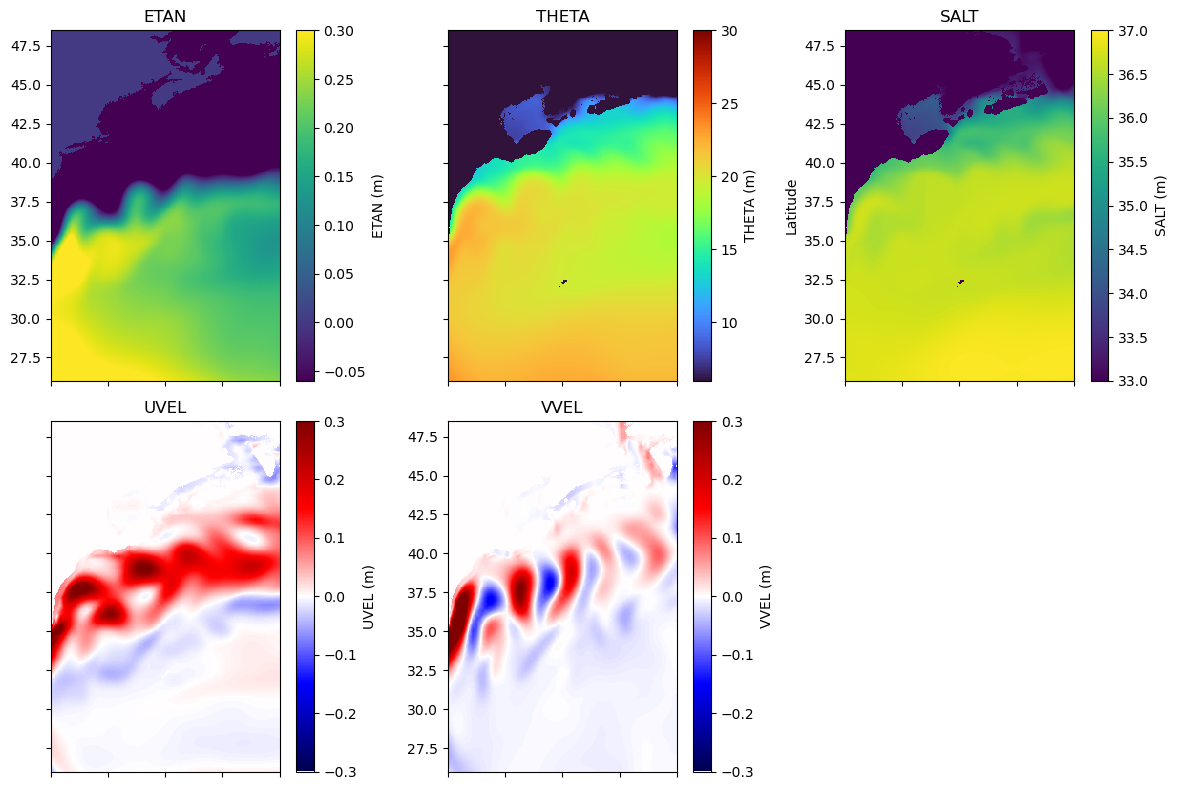

In [24]:
fig = plt.figure(figsize=(12,8))


for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    EastCoast_init_grid = np.fromfile(os.path.join(input_dir,variable_name+'_IC.bin'),'>f4')

    if variable_name == 'ETAN':
        EastCoast_init_grid = EastCoast_init_grid.reshape((np.shape(XC)[0], np.shape(XC)[1]))
    else:
        EastCoast_init_grid = EastCoast_init_grid.reshape((np.shape(delR)[0],np.shape(XC)[0], np.shape(XC)[1]))
        EastCoast_init_grid = EastCoast_init_grid[10, :, :] # choose just the surface for plotting
    
    plt.subplot(2,3,i+1)
    C = plt.pcolormesh(XC, YC, EastCoast_init_grid,
                       vmin=meta_dict[variable_names[i]][0],
                       vmax=meta_dict[variable_names[i]][1],
                       cmap=meta_dict[variable_names[i]][2])
    plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.26)

    if i<5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel('Longitude')
    if i%2==1:
        plt.gca().set_yticklabels([])
    if i==7:
        plt.gca().axis('off')
    if i==2:
        plt.gca().set_ylabel('Latitude')
    plt.title(variable_name)

plt.tight_layout()

plt.show()